In [ ]:
# Proyecto Integrador – Módulo 6  
## Notebook 01: Exploración y Visualización de Datos

#En este notebook se realiza:
""" 
- Definición del problema.
- Carga inicial de datos (texto e imágenes).
- Análisis exploratorio de datos (EDA).
- Visualizaciones iniciales para comprender la distribución de los datos.
"""


In [ ]:
## 1. Definición del Problema
"""
Este proyecto integra Procesamiento de Lenguaje Natural (PLN), análisis de imágenes y aprendizaje por refuerzo para construir un sistema inteligente que apoye la priorización de casos de soporte.

Cada caso de soporte puede incluir:

- Un mensaje de texto del cliente.
- Opcionalmente, una imagen del rostro del cliente.

El sistema utiliza:

- PLN para calcular el sentimiento del texto.
- Redes neuronales convolucionales (CNN) para detectar la emoción facial.
- Aprendizaje por refuerzo (RL) para decidir si un caso debe:
  - Atenderse de inmediato
  - Pasar a cola normal
  - Ser enviado a revisión especial

Este notebook inicia con la exploración y visualización de los datos.

"""

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

print("Entorno listo para EDA 🚀")


Entorno listo para EDA 🚀


In [2]:
from tensorflow.keras.datasets import imdb

# Tamaño máximo de vocabulario
VOCAB_SIZE = 10000

# Cargar el dataset IMDB desde Keras
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

len(X_train), len(X_test), set(y_train)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


(25000, 25000, {np.int64(0), np.int64(1)})

In [3]:
# Obtener diccionario palabra -> índice
word_index = imdb.get_word_index()

# Invertir el diccionario: índice -> palabra
index_to_word = {index + 3: word for word, index in word_index.items()}
index_to_word[0] = "<PAD>"
index_to_word[1] = "<START>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

def decode_review(encoded_review):
    return " ".join(index_to_word.get(i, "?") for i in encoded_review)

# Probar con el primer ejemplo
print("Etiqueta:", y_train[0])
print("Texto decodificado:\n")
print(decode_review(X_train[0])[:500], "...")


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Etiqueta: 1
Texto decodificado:

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would re ...


In [4]:
# Convertir una muestra del dataset a DataFrame para EDA
N_SAMPLES = 5000  # usamos 5,000 para que sea manejable

texts = [decode_review(seq) for seq in X_train[:N_SAMPLES]]
labels = y_train[:N_SAMPLES]

df_text = pd.DataFrame({
    "text": texts,
    "label": labels
})

df_text.head()


,text,label
0,<START> this film was just brilliant casting l...,1
1,<START> big hair big boobs bad music and a gia...,0
2,<START> this has to be one of the worst films ...,0
3,<START> the <UNK> <UNK> at storytelling the tr...,1
4,<START> worst mistake of my life br br i picke...,0


In [5]:
df_text['label'].value_counts().rename(index={0: "negativa", 1: "positiva"})


label
positiva    2546
negativa    2454
Name: count, dtype: int64

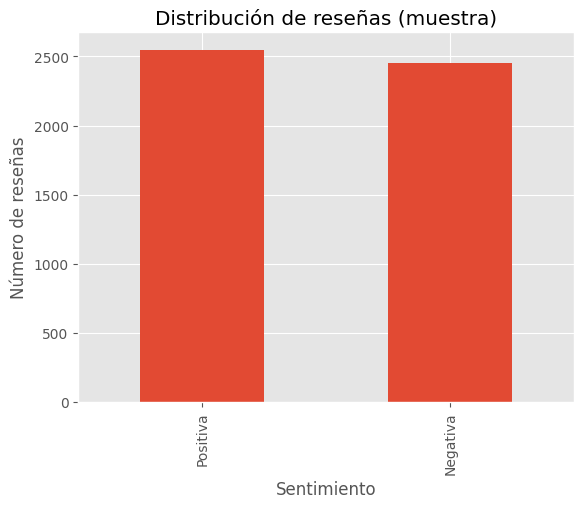

In [6]:
df_text['label'].map({0: "Negativa", 1: "Positiva"}).value_counts().plot(kind="bar")
plt.title("Distribución de reseñas (muestra)")
plt.xlabel("Sentimiento")
plt.ylabel("Número de reseñas")
plt.show()


In [7]:
df_text['text_length'] = df_text['text'].str.split().apply(len)

df_text['text_length'].describe()


count    5000.00000
mean      243.81940
std       179.89464
min        16.00000
25%       130.00000
50%       182.00000
75%       301.00000
max      1851.00000
Name: text_length, dtype: float64

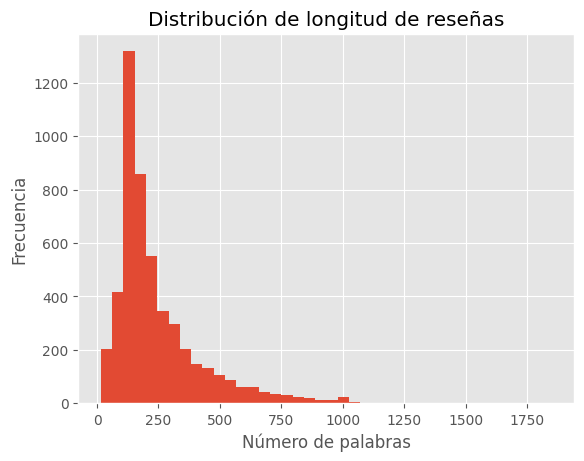

In [8]:
df_text['text_length'].hist(bins=40)
plt.title("Distribución de longitud de reseñas")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:
### 2. Modelo de PLN para análisis de sentimiento (IMDB)

In [9]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers

# 1) Cargar nuevamente el dataset desde Keras (para uso directo en el modelo)
VOCAB_SIZE = 10000
MAX_LEN = 200  # longitud máxima de cada reseña (en palabras/tokens)

(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = imdb.load_data(num_words=VOCAB_SIZE)

len(X_train_raw), len(X_test_raw)


(25000, 25000)

In [10]:
X_train = pad_sequences(X_train_raw, maxlen=MAX_LEN, padding='pre', truncating='pre')
X_test = pad_sequences(X_test_raw, maxlen=MAX_LEN, padding='pre', truncating='pre')

X_train.shape, X_test.shape


((25000, 200), (25000, 200))

In [11]:
model_pln = models.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # salida entre 0 y 1 (sentimiento negativo/positivo)
])

model_pln.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_pln.summary()


e:\Proyecto Integrador\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
EPOCHS = 4
BATCH_SIZE = 128

history_pln = model_pln.fit(
    X_train,
    y_train_raw,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)


Epoch 1/4
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 203ms/step - accuracy: 0.7332 - loss: 0.5085 - val_accuracy: 0.8524 - val_loss: 0.3606
Epoch 2/4
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.8939 - loss: 0.2719 - val_accuracy: 0.8618 - val_loss: 0.3194
Epoch 3/4
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - accuracy: 0.9270 - loss: 0.2034 - val_accuracy: 0.8562 - val_loss: 0.3503
Epoch 4/4
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 181ms/step - accuracy: 0.9477 - loss: 0.1520 - val_accuracy: 0.8680 - val_loss: 0.4016


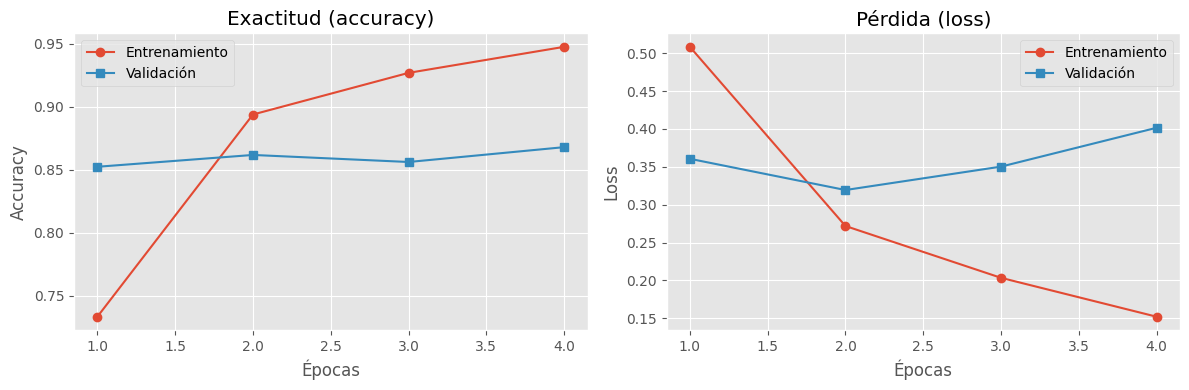

In [13]:
def plot_training_history(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'o-', label='Entrenamiento')
    plt.plot(epochs, val_acc, 's-', label='Validación')
    plt.title('Exactitud (accuracy)')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'o-', label='Entrenamiento')
    plt.plot(epochs, val_loss, 's-', label='Validación')
    plt.title('Pérdida (loss)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_pln)


In [14]:
test_loss, test_acc = model_pln.evaluate(X_test, y_test_raw, verbose=0)
print(f"Loss en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_acc:.4f}")


Loss en test: 0.4419
Accuracy en test: 0.8534


In [15]:
import os

os.makedirs("models", exist_ok=True)
model_pln.save("models/modelo_pln_imdb.h5")
